# Conditional Generative Adversarial Network (CGAN)

Conditional Generative Adversarial Nets - [Paper](https://arxiv.org/pdf/1411.1784.pdf)

Conditional GANs are constructed by feeding the data we wish to condition on to both the generator and discriminator.

$\min\limits_G\max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)} [log D(x|y)] + \mathbb{E}_{z\sim p_z(z)} [log(1 - D(G(z|y)))]$

<img align="center" src="https://user-images.githubusercontent.com/27071473/84100915-6b6a1f80-aa3f-11ea-976b-a2b53e449205.png" width=40%>

Note: The following implementation is for continuous variables. For discrete variables, implement an embedding layer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf

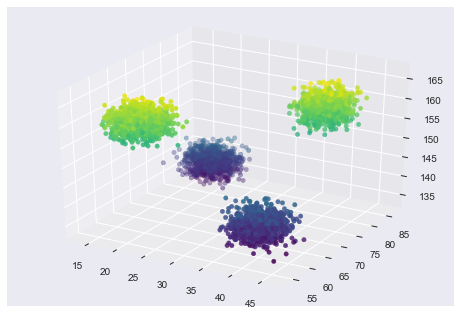

In [9]:
from data.synthetic import get_tf_normal_dataset, plot_data

X, y, dataset = get_tf_normal_dataset(1000, xy_features=(2,1), plot=True)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

class CGAN:
    """Generate y conditioned on x."""
    def __init__(self, x_features, y_features, latent_dim, batch_size=32):
        self.x_features = x_features
        self.y_features = y_features
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.loss = BinaryCrossentropy()
        self.g_optimizer = Adam(1e-4)
        self.d_optimizer = Adam(1e-4)
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.generator.summary()
        self.discriminator.summary()
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))  # noise
        d_noise = Dense(16)(noise)
        x = Input(shape=(self.x_features,))  # condition
        d_x = Dense(16)(x)
        z = Concatenate()([d_noise, d_x])
        d_z = Dense(16)(z)
        y = Dense(self.y_features)(d_z)
        return Model([noise, x], y)
    
    def build_discriminator(self):
        x = Input(shape=(self.x_features))  # condition
        d_x = Dense(16)(x)
        y = Input(shape=(self.y_features))  # y
        d_y = Dense(16)(y)
        h = Concatenate()([d_x, d_y])
        h = Dense(16)(h)
        h = Dropout(0.4)(h)
        p = Dense(1, activation='sigmoid')(h)
        model = Model([y, x], p)
        return model
    
    def g_loss(self, fake_y):
        return self.loss(tf.ones_like(fake_y), fake_y)
    
    def d_loss(self, real_y, fake_y):
        return 0.5 * (self.loss(tf.ones_like(real_y), real_y) + self.loss(tf.zeros_like(fake_y), fake_y))
    
    @tf.function
    def train_step(self, X, real_y):
        noise = tf.random.normal((X.shape[0], self.latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_y = self.generator([noise, X], training=True)
            
            real_pred = self.discriminator([real_y, X], training=True)
            fake_pred = self.discriminator([fake_y, X], training=True)
            
            g_loss = self.g_loss(fake_pred)
            d_loss = self.d_loss(real_pred, fake_pred)
            
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        return g_loss, d_loss
    
    def fit(self, dataset, epochs=1000):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            for X_train, y_train in dataset:
                g_loss, d_loss = self.train_step(X_train, y_train)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
            if epoch % (epochs // 10) == 0:
                print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
        plt.plot(g_losses, label='g_loss')
        plt.plot(d_losses, label='d_loss')
        plt.legend(loc='best')
        plt.show()
        
    def sample(self, X):
        noise = np.random.normal(0, 1, (X.shape[0], self.latent_dim)).astype(np.float32)
        return self.generator([noise, X]).numpy()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 16)           528         input_9[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           48          input_10[0][0]                   
____________________________________________________________________________________________

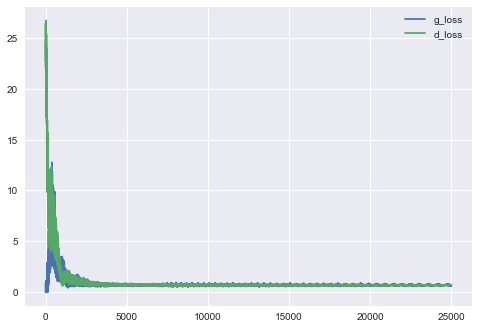

In [12]:
# from model.cgan import CGAN

latent_dim=32
cgan = CGAN(x_features=2,
            y_features=1,
            latent_dim=latent_dim)
cgan.fit(dataset, epochs=200)
y_hat = cgan.sample(X)

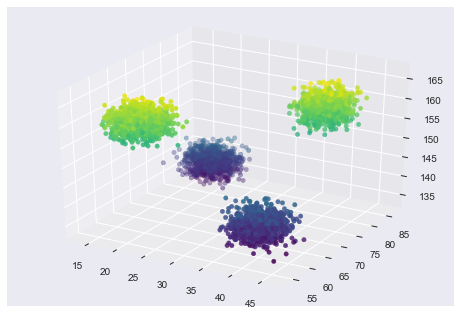

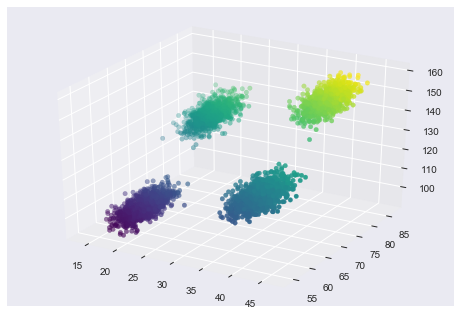

In [13]:
plot_data(X, y)
plot_data(X, y_hat)

In [ ]:
from visualisation.visualisation import Visualisation

viz = Visualisation(cgan, X, y)

# Plot the density function based on X1 and X2
viz.plot_prob(X[:,0], y[:,0], bins=20)
viz.plot_prob(X[:,1], y[:,0], bins=20)

# Plot probability density function given X_fixed across y_range.
# viz.plot_prob_fixed(X_fixed=(20,60), y_range=[0,200], count=200)

# Given X, plot a violin of y based on X within a tolerance, to compare the distribution between fitted and actual.
# X_tol represents the tolerance to which X data is binned to get the corresponding y.
# X_fixed represents the X fed into the model to sample y.
viz.plot_prob_violin(X_fixed=(20,60), X_tol=(0.1,0.1))

# Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
# For the actual distribution, bin X and plot violin plots for the density of y.
# For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
viz.plot_binned_violin(bins=5)